# Factorisation de matrice creuse avec descente de gradient stochastique sur GPU
**Auteurs:** Thomas Levy & Selim Dekali (17/01/2018)
    
Ce notebook explique notre projet pour Eléments logiciels pour le traitement des données massives.

Nous nous sommes basés sur les articles suivant:
* [Hogwild!: A Lock-Free Approach to Parallelizing Stochastic Gradient Descent](https://arxiv.org/pdf/1106.5730v2.pdf)
* [CuMF_SGD: Fast and Scalable Matrix Factorization](https://arxiv.org/pdf/1610.05838.pdf)


Nous avons utilisé *PyCuda* pour paralléliser l'éxecution sur GPU.
        

## Contexte
Le but est de factoriser une matrice R creuse à grande dimension en:
R = P x Q
![mf.png](mf.png)

## Pourquoi?
L'intéret est:
* d'une part de pouvoir économiser l'espace de stockage en stoquant P et Q de dimension moindre plutot que R de grande dimension.
* d'autre part la factorisation de matrice est utiliseé pour les systemes de rating, lorsque l'on veut prédire la valeur des rating inconnus à partir d'un rating connu. 
C'est pourquoi on parle de matrice R de rating. 

## Hogwild
Hogwild est une approche sans-verrou pour paralléliser le problème avec méthode SGD (de descente de gradient stochastique).
Elle repose sur les constatations suivantes:
* Pour une matrice creuse de grande taille, la probablilité que des threads concurrents modifient les même lignes ou colonnes de P et Q en même temps est très faible.
* De plus, l'impact d'un conflit s'il survenait rarement est négligable sur la précision de l'algorithme.
En conséquence, si le nombre de threads paralleles est limité par rapport au nombres d'éléments (non nuls) dans la matrice R, il n'y a pas de besoin de mettre en place de mécanisme de protection particulier vis à vis d'éventuelles écritures concurrentes.


## Algorithmes
Nous avons implémenté la factorisation de matrice avec résolution avec une méthode SGD avec Hogwild.

Nous avons utilisé les algorithmes suivants:

### Version simple (non parallélisée)
* Création d'une liste des éléments non creux de la matrice R => samples
* Boucle sur le nombre d'itérations:
    * shuffle(samples)
    * Boucle sur les éléments de samples:
        * Evalue l'erreur de prédiction actuelle pour l'élément
        * Met à jour les lignes de P et Q correspondant à l'élément avec une descente de gradient 

### Version distribuée (sur GPU)
**Sur CPU:**
* Création d'une liste des éléments non creux de la matrice R => samples
* Boucle sur le nombre d'itérations:
    * shuffle(samples)
    * Lance sgd_gpu(samples,P,Q) sur n threads
    * Synchronize(all threads)
    

**Sur GPU sgd_gpu(samples,P,Q):**
* Identifie le thread actif => Partie i
* Boucle sur les éléments de la partie i de samples:
    * Evalue l'erreur de prédiction actuelle pour l'élément
    * Met à jour les lignes de P et Q correspondant à l'élément avec une descente de gradient 


## Code PyCuda (Python/C):
Import des librairies

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import time
import random

### Function coté GPU (device):

In [2]:
mod = SourceModule("""
  #include <stdio.h>

  __global__ void sgd_gpu(float *P, float *Q, float alpha, float beta, int k, int nsamples, float *samples, int nThreads, int nBlocks)
  {    
    int s=0;
    int threadId=threadIdx.x;
    int blockId=blockIdx.x;
    int threadNum= blockId*nThreads + threadId;
    for ( s = 0+threadNum; s < nsamples; s = s + ( nThreads * nBlocks )) {
     int i=samples[s*3];
     int j=samples[s*3+1];
     
     double rating= samples[s*3+2];
     //printf("Tid:%d s:%d i:%d j:%d rating:%f\\n",threadId,s,i,j,rating);    
     double prediction = 0;
     int a;
     for( a = 0; a < k; a = a + 1 ){
      prediction=prediction+(P[i*k+a]*Q[j*k+a]);
      if (a%10==0) {
        //printf("a:%d pred:%f\\n",a,prediction);
      }
     }
     double e = rating - prediction;
     //printf("Tid:%d i:%d j:%d rating:%f e:%f %f\\n",threadId,i,j,rating,e,prediction);
     for( a = 0; a < k; a = a + 1 ){
      P[i*k+a] = P[i*k+a] + alpha * ( 2*e * Q[j*k+a] - beta * P[i*k+a]);
      Q[j*k+a] = Q[j*k+a] + alpha * ( 2*e * P[i*k+a] - beta * Q[j*k+a]);                        
     }                
    }
    __syncthreads();      
  }         
  """)

### Classe de Factorisation coté CPU:
Cette classe fait la factorisation de matrice en distribué ou en pur CPU avec les méthodes:
* factorize_gpu: en précisant le nombre de threads, blocks utilisés sur GPU 
* factorize_cpu: factorisation non parallélisée sur CPU


In [3]:
# Class that does matrix factorization
class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Contructor

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R.astype(np.float32)
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        

    
    def factorize_cpu(self):
        # Initialize P & Q
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))


        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        t0 = time.clock()
        factorize_steps = []
        mse = self.mse2()
        step = (0,mse)
        factorize_steps.append(step)
        print("[Factorize_CPU] Initial error = %.4f" % (mse))
        # Perform stochastic gradient descent for number of iterations
        #training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd2()
            #mse = self.mse2()
            #training_process.append((i, mse))
            if (i+1) % 5 == 0:
                #print("Iteration: %d ; error = %.4f" % (i+1, mse))
                mse = self.mse2()
                elapsed= time.clock()-t0
                print("Iteration: %d;elapsed = %.2f ; error = %.4f" % (i+1,elapsed, mse))
                step = (elapsed,mse)
                factorize_steps.append(step)

        return factorize_steps

    def mse2(self):
        # Compute the total mean square error
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix2()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return error/len(xs)
    

    def sgd2(self):
        """
        Perform stochastic gradient descent (on CPU host)
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating2(i, j)
            e = (r - prediction)

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (2*e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (2*e * self.P[i, :] - self.beta * self.Q[j,:])

                 
    def factorize_gpu(self, nThreads=1, nBlocks=1):
        #It does the matrix factorization on gpu
        func = mod.get_function("sgd_gpu")
        
        #Intialize P & Q
        self.P = np.random.normal(scale=1.0/self.K, size=(self.num_users, self.K)).astype(np.float32)
        self.Q = np.random.normal(scale=1.0/self.K, size=(self.num_items, self.K)).astype(np.float32)       
                
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        #Converted into an array of int32 for passing to GPU
        samplesA = np.asarray(self.samples).astype(np.float32)        
        nSamples = samplesA.shape[0]
        
        mse = self.mse2()
        print("[Factorize_gpu] Initial error = %.4f" % (mse))
        t0 = time.clock()
        factorize_steps = []
        step = (0,mse)
        #factorize_steps.append((0, step))
        factorize_steps.append(step)
        for i in range(self.iterations):
            np.random.shuffle(samplesA)
            func(cuda.InOut(self.P), cuda.InOut(self.Q), np.float32(self.alpha), np.float32(self.beta), np.int32(self.K), np.int32(nSamples),cuda.In(samplesA), np.int32(nThreads), np.int32(nBlocks),grid=(nBlocks,1), block=(nThreads,1,1))            
            if (i+1) % 5 == 0:
                mse = self.mse2()
                elapsed= time.clock()-t0
                print("Iteration: %d;elapsed = %.2f ; error = %.4f" % (i+1,elapsed, mse))
                step = (elapsed,mse)
                factorize_steps.append(step)
        return factorize_steps
    
    
    def get_rating2(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    
    def full_matrix2(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return mf.P.dot(mf.Q.T)

### Creation d'une matrice aléatoire de test:

In [4]:
def random_sparse_matrix(shape, ratio_sparse=0.2):
    rnd = np.random.binomial(5,0.5,shape[0] * shape[1])
    #sparse = 0
    for i in range(0, len(rnd)):
        x = random.random()
        if x> ratio_sparse:
            rnd[i] = 0
    rnd.resize(shape[0], shape[1])
    return rnd


R = random_sparse_matrix((200, 200),0.2)

### Factorisation sur GPU vs CPU
On compare la factorisation de cette matrice en pur CPU avec une factorisation distribuée avec 2 et 32 threads

[Factorize_gpu] Initial error = 7.7067
Iteration: 5;elapsed = 0.86 ; error = 0.9942
Iteration: 10;elapsed = 1.74 ; error = 0.8391
Iteration: 15;elapsed = 2.58 ; error = 0.4252
Iteration: 20;elapsed = 3.40 ; error = 0.1609
Iteration: 25;elapsed = 4.22 ; error = 0.0685
Iteration: 30;elapsed = 5.03 ; error = 0.0332
Iteration: 35;elapsed = 5.85 ; error = 0.0178
Iteration: 40;elapsed = 6.67 ; error = 0.0104
Iteration: 45;elapsed = 7.48 ; error = 0.0065
Iteration: 50;elapsed = 8.29 ; error = 0.0043
[Factorize_gpu] Initial error = 7.7068
Iteration: 5;elapsed = 0.14 ; error = 1.0004
Iteration: 10;elapsed = 0.27 ; error = 0.8725
Iteration: 15;elapsed = 0.40 ; error = 0.5057
Iteration: 20;elapsed = 0.54 ; error = 0.2056
Iteration: 25;elapsed = 0.68 ; error = 0.0917
Iteration: 30;elapsed = 0.81 ; error = 0.0464
Iteration: 35;elapsed = 0.95 ; error = 0.0256
Iteration: 40;elapsed = 1.09 ; error = 0.0153
Iteration: 45;elapsed = 1.23 ; error = 0.0095
Iteration: 50;elapsed = 1.36 ; error = 0.0063
[Fac

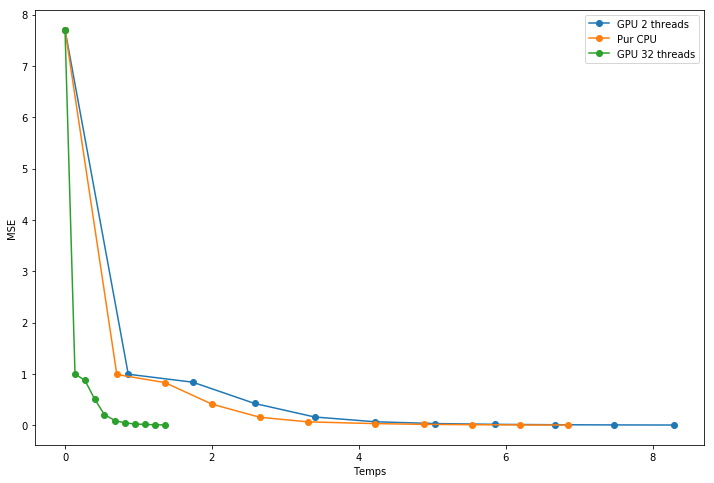

In [5]:
mf = MF(R, K=50, alpha=0.01, beta=0.01, iterations=50)

steps= mf.factorize_gpu(nThreads=2)
steps2= mf.factorize_gpu(nThreads=32)
steps3= mf.factorize_cpu()


fig=plt.figure(figsize=(12,8))
#plt.subplot(111)
ax1 = fig.add_subplot(1,1,1)
x_val = [x[0] for x in steps]
y_val = [x[1] for x in steps]
ax1.plot(x_val,y_val,marker='o',linestyle='-',label='GPU 2 threads')
x_val = [x[0] for x in steps3]
y_val = [x[1] for x in steps3]
ax1.plot(x_val,y_val,marker='o',linestyle='-',label='Pur CPU')
x_val = [x[0] for x in steps2]
y_val = [x[1] for x in steps2]
ax1.plot(x_val,y_val,marker='o',linestyle='-',label='GPU 32 threads')
ax1.set_xlabel('Temps')
ax1.set_ylabel('MSE')
ax1.legend(loc='best')
plt.show()

On constate que le temps de traitement avec 2 threads sur GPU est plus long que pour un traitement non distribué.
Donc il y a un cout au passage sur GPU.
Mais, avec 32 threads sur GPU, le traitement est déja nettement plus rapide en distribué.

### Factorisation sur plusieurs blocs
Le traitement etait fait jusqu'à maintenand sur plusieurs threads d'un même bloc, on va vérifier si on peut répartir le traitement sur plusieurs blocs.
On va pour cela utiliser une matrice R de grande taille (1000x1000)


[Factorize_gpu] Initial error = 7.7287
Iteration: 5;elapsed = 4.75 ; error = 1.0670
Iteration: 10;elapsed = 9.26 ; error = 0.4082
Iteration: 15;elapsed = 13.78 ; error = 0.1802
Iteration: 20;elapsed = 18.44 ; error = 0.1127
Iteration: 25;elapsed = 22.99 ; error = 0.0823
Iteration: 30;elapsed = 27.56 ; error = 0.0648
Iteration: 35;elapsed = 32.07 ; error = 0.0540
Iteration: 40;elapsed = 36.72 ; error = 0.0462
Iteration: 45;elapsed = 41.23 ; error = 0.0405
Iteration: 50;elapsed = 45.72 ; error = 0.0364
[Factorize_gpu] Initial error = 7.7288
Iteration: 5;elapsed = 2.44 ; error = 1.0628
Iteration: 10;elapsed = 4.83 ; error = 0.4063
Iteration: 15;elapsed = 7.23 ; error = 0.1782
Iteration: 20;elapsed = 9.64 ; error = 0.1128
Iteration: 25;elapsed = 12.06 ; error = 0.0824
Iteration: 30;elapsed = 14.45 ; error = 0.0653
Iteration: 35;elapsed = 16.89 ; error = 0.0535
Iteration: 40;elapsed = 19.31 ; error = 0.0458
Iteration: 45;elapsed = 21.72 ; error = 0.0402
Iteration: 50;elapsed = 24.12 ; error

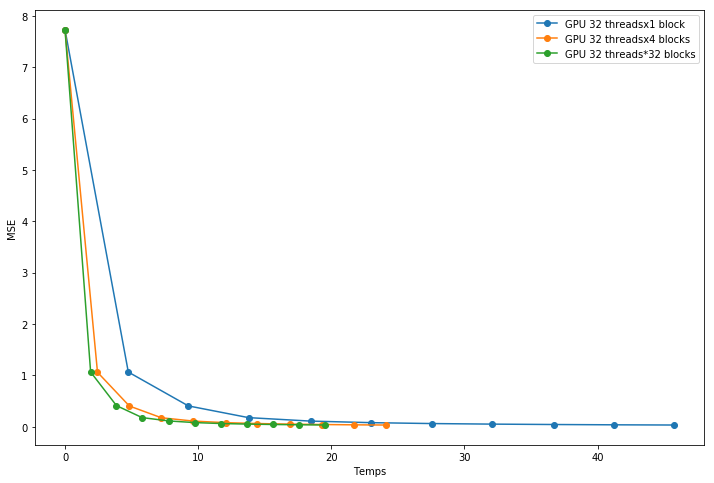

In [6]:
R2 = random_sparse_matrix((1000, 1000),0.2)
mf = MF(R2, K=100, alpha=0.01, beta=0.01, iterations=50)

steps3= mf.factorize_gpu(nThreads=32)
steps4= mf.factorize_gpu(nThreads=32,nBlocks=4)
steps5= mf.factorize_gpu(nThreads=32,nBlocks=32)
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)
x_val = [x[0] for x in steps3]
y_val = [x[1] for x in steps3]
ax1.plot(x_val,y_val,marker='o',linestyle='-',label='GPU 32 threadsx1 block')
#ax1.plot(*zip(*steps),marker='o',linestyle='-',label='2 threads')
x_val = [x[0] for x in steps4]
y_val = [x[1] for x in steps4]
ax1.plot(x_val,y_val,marker='o',linestyle='-',label='GPU 32 threadsx4 blocks')
#ax1.plot(*zip(*steps3),marker='o',linestyle='-',label='Pur CPU')
x_val = [x[0] for x in steps5]
y_val = [x[1] for x in steps5]
ax1.plot(x_val,y_val,marker='o',linestyle='-',label='GPU 32 threads*32 blocks')
ax1.set_xlabel('Temps')
ax1.set_ylabel('MSE')
ax1.legend(loc='best')
plt.show()

## Conclusion
Grace à cette implémentation, nous avons donc montré que la performance de l'algo de factorisation de matrice avec SGD et Hogwild est meilleure lorsque le nombre de blocs et de threads paralleles utilisés augmente.
